In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
import cv2
from PIL import Image
import os
import zipfile
import logging
import json
import foolbox
from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.optimizers import Nadam, Adam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1, l2, l1_l2


import alibi_detect.ad as adv
from alibi_detect.datasets import fetch_traffic_signs
from alibi_detect.models.losses import loss_adv_vae
from alibi_detect.ad import AdversarialVAE
from alibi_detect.utils.saving import save_detector, load_detector, save_tf_model, load_tf_model
from alibi_detect.utils.visualize import plot_instance_score


Using TensorFlow backend.
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
from inspect import signature
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve, f1_score
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
%matplotlib inline
from scipy.stats import percentileofscore
from importlib import reload

In [3]:
from sklearn.metrics import confusion_matrix
%set_env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


# Load mnist

In [4]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


# Model

In [5]:
model = tf.keras.models.load_model('/home/gio/adversarial_vae/adversarial-vae/models/classifier/mnist/model/model.h5')

In [6]:
# evaluate model
results = model.evaluate(X_test, y_test, batch_size=256, verbose=0)
print('Test loss: {:.4f} -- accuracy: {:.4f}'.format(results[0], results[1]))

Test loss: 0.0251 -- accuracy: 0.9928


In [7]:
fmodel = foolbox.models.TensorFlowEagerModel(model, bounds=(0, 1))

In [16]:
x_test = X_test[100:200]
labels_test = np.argmax(fmodel.forward(x_test), axis=1)

In [17]:
import logging
logging.basicConfig(level=logging.WARNING)
attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)

In [18]:
advs_da = attack(x_test, labels_test)

/home/gio/git/foolbox-fork/foolbox/attacks/base.py:95: UserWarning: CarliniWagnerL2Attack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


In [19]:
X_to_adv = x_test
X_adv = advs_da

In [20]:
y_val = np.concatenate((np.zeros(len(X_to_adv)), np.ones(len(X_adv))))
X_val = np.concatenate([X_to_adv, X_adv], axis=0)

In [24]:
load_adversarial_detector = False

log_dir = '/home/gio/experiments/mnist/model_0/vae_0/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
data_dir = '/'.join(log_dir.split('/')[:-3]) + '/'
model_dir = '/'.join(log_dir.split('/')[:-2]) + '/'
detector_dir = '/'.join(log_dir.split('/')[:-1]) + '/'

encoder_params = {'nb_filters_1': 64, 'nb_filters_2': 128, 'nb_filters_3': 512,
               'kernel_1': 4, 'kernel_2': 4, 'kernel_3': 4,
               'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu',
                'padding_1': 'same', 'padding_2': 'same', 'padding_3': 'same'}
decoder_params = {'nb_filters_1': 64, 'nb_filters_2': 32, 'nb_filters_3': 1,
               'kernel_1': 3, 'kernel_2': 3, 'kernel_3': 3, 
               'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'sigmoid',
               'padding_1': 'same', 'padding_2': 'same', 'padding_3': 'same',}
vae_params = {'latent_dim': 160, 'optimizer': 'Adam'}

filepath = detector_dir # change to directory where model is downloaded
if load_adversarial_detector:  # load pretrained adversarial detector
    ad = load_detector(filepath)
else:  # define model, initialize, train and save adversarial detector
    latent_dim = vae_params['latent_dim']
    alpha = 0.
    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(28, 28, 1)),
          #Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=1, 
          #       padding=encoder_params['padding_1'], activation=encoder_params['activation_1'],
          #      kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_1'], encoder_params['kernel_1'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_1'],
                kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_2'], encoder_params['kernel_2'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_2'],
                kernel_regularizer=l2(alpha)),
          Conv2D(encoder_params['nb_filters_3'], encoder_params['kernel_3'], strides=2, 
                 padding=encoder_params['padding_1'], activation=encoder_params['activation_3'],
                kernel_regularizer=l2(alpha))
      ])
    
    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(7*7*28, activation=tf.nn.relu),
          Reshape(target_shape=(7, 7, 28)),
          Conv2DTranspose(decoder_params['nb_filters_1'], decoder_params['kernel_1'], strides=2, 
                         padding=decoder_params['padding_1'], activation=decoder_params['activation_1'],
                         kernel_regularizer=l2(alpha)),
          Conv2DTranspose(decoder_params['nb_filters_2'], decoder_params['kernel_2'], strides=2, 
                          padding=decoder_params['padding_1'], activation=decoder_params['activation_2'],
                         kernel_regularizer=l2(alpha)),
          Conv2DTranspose(decoder_params['nb_filters_3'], decoder_params['kernel_3'], strides=1, 
                          padding=decoder_params['padding_1'], activation=decoder_params['activation_3'],
                         kernel_regularizer=l2(alpha))
      ])

    runs = next(os.walk(log_dir))[1]
    run_id = 0
    while str(run_id) in runs:
        run_id += 1
    
    run_dir = log_dir + str(run_id)
    print('Creating log dir:', run_dir)
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)    
    
    if vae_params['optimizer'] == 'Adam':
        opt = Adam()
    elif vae_params['optimizer'] == 'Nadam':
        opt = Nadam()
    elif vae_params['optimizer'] == 'RMSprop':
        opt = RMSprop()
    elif vae_params['optimizer'] == 'SGD':
        opt = SGD(momentum=0.9)
        
    # initialize adversarial detector
    ad = AdversarialVAE(threshold=.5,  # threshold for adversarial score
                        model=model,
                        encoder_net=encoder_net,  # can also pass VAE model instead
                        decoder_net=decoder_net,  # of separate encoder and decoder
                        latent_dim=latent_dim,
                        samples=2,  # nb of samples drawn by VAE
                        beta=0.  # weight on KL-divergence loss term of latent space
                       )
    


Creating log dir: /home/gio/experiments/mnist/model_0/vae_0/102


In [25]:
    # train
    ad.fit(X_train,
           validation_data=(X_test[100:200], None),
           adversarial_data=(X_val, y_val),
           loss_fn=loss_adv_vae,
           w_model=1.,  # weight on KL-divergence loss term of model predictions
           w_recon=0.,  # weight on elbo loss term
           optimizer=opt,
           epochs=6,
           verbose=True,
          log_metric_val='acc',
          log_dir=run_dir)

938/938 [=] - 31s 33ms/step - loss: 0.3130
Accuracy improved from 0 to 0.84. Saving model in /home/gio/experiments/mnist/model_0/vae_0/102/best.ckpt
938/938 [=] - 31s 33ms/step - loss: 0.0469
Accuracy improved from 0.84 to 0.895. Saving model in /home/gio/experiments/mnist/model_0/vae_0/102/best.ckpt
938/938 [=] - 31s 33ms/step - loss: 0.0316
Accuracy improved from 0.895 to 0.915. Saving model in /home/gio/experiments/mnist/model_0/vae_0/102/best.ckpt
938/938 [=] - 31s 33ms/step - loss: 0.0199
Accuracy improved from 0.915 to 0.97. Saving model in /home/gio/experiments/mnist/model_0/vae_0/102/best.ckpt
938/938 [=] - 31s 33ms/step - loss: 0.0171
Accuracy did not improve. Saving model in /home/gio/experiments/mnist/model_0/vae_0/102/last.ckpt 
938/938 [=] - 31s 33ms/step - loss: 0.0153
Accuracy did not improve. Saving model in /home/gio/experiments/mnist/model_0/vae_0/102/last.ckpt 
939/938 [=] - 31s 33ms/step - loss: 0.0153 - detection_acc: 0.9200 - detection_f1: 0.9259


In [26]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (28, 28)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(10, 10 + n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    #class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    #image = Image.fromarray(class_image, 'RGB')
    #image = np.array(image)
    #ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    #class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    #image_adv = Image.fromarray(class_image_adv, 'RGB')
    #image_adv = np.array(image_adv)   
    #ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')

IndexError: index 10 is out of bounds for axis 0 with size 5

<Figure size 1080x1440 with 0 Axes>

In [27]:
ad.vae.load_weights('/home/gio/experiments/mnist/model_0/vae_0/102/best.ckpt')
ad.infer_threshold(X_train[:2000], threshold_perc=95.)
ad.threshold

0.036017707549035535

In [28]:
y_adv = y_test[100:200]
y_adv = np.argmax(y_adv, axis=1)

In [29]:
loss_ws, accs_no_attack, accs_attack, accs_defence = [], [], [], []
print('Attacking ...')
model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)
for loss_w in np.arange(0., 1.0, 0.1):
    print('ad loss weight:', loss_w)
    attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)
    X_adv = attack(x_test, labels_test, detector=ad, loss_w=loss_w)
    
    preds_xtoadv = np.argmax(model(X_to_adv).numpy(), axis=1)
    preds_adv = np.argmax(model(X_adv).numpy(), axis=1)
    #X_concat = np.concatenate((X_to_adv, X_adv))
    #preds_concat = np.concatenate((preds_xtoadv, preds_adv))
    #y_adv_concat = np. concatenate((y_adv, y_adv))
    
    loss_ws.append(loss_w)
    accs_no_attack.append(accuracy_score(preds_xtoadv, y_adv))
    accs_attack.append(accuracy_score(preds_adv, y_adv))
    
    nb_rep = 10
    nb_classes = 10
    nb_samples = len(X_adv)
    concatenation = tuple([X_adv for _ in range(nb_rep)])
    shape_0 = (X_adv.shape[0], nb_rep) + X_adv.shape[1:]
    X_adv_conc = np.concatenate(concatenation, axis=1).reshape(shape_0)
    shape_1 = (X_adv_conc.shape[0] * X_adv_conc.shape[1], ) + X_adv_conc.shape[2:]
    X_adv_fin = X_adv_conc.reshape(shape_1)
    
    preds_adv_trans = model.predict(ad.vae(X_adv_fin).numpy())
    preds_adv_trans = preds_adv_trans.reshape(nb_samples, nb_rep, nb_classes)
    #preds_fin = mode(np. argmax(preds_adv_trans, axis=1), axis=1)[0]
    preds_fin = np.mean(preds_adv_trans, axis=1)
    preds_fin = np.argmax(preds_fin, axis=1)

    accs_defence.append(accuracy_score(preds_fin, y_adv))
print('Done!')
df = pd.DataFrame()
df['loss_w'] = loss_ws
df['acc_no_attack'] = accs_no_attack
df['acc_attack'] = accs_attack
df['acc_defence'] = accs_defence
df.set_index('loss_w', inplace=True)

Attacking ...
ad loss weight: 0.0


KeyboardInterrupt: 

In [15]:
import tensorflow
def get_detector_gradients(x, detector):
    x = tensorflow.convert_to_tensor(x)
    loss = tensorflow.keras.losses.kld

    with tensorflow.GradientTape() as g:
      g.watch(x)
      x_trans = detector.vae(x)
      prob_orig = tensorflow.nn.softmax(detector.model(x))
      prob_trans = tensorflow.nn.softmax(detector.model(x_trans))
      loss_val = -loss(prob_orig, prob_trans)

    gradients = g.gradient(loss_val, x)
    return gradients.numpy()

In [16]:
x = x_test[:1]

In [30]:
grads = get_detector_gradients(x, ad)

In [32]:
grads.shape

(1, 28, 28, 1)

In [11]:
#advs_0 = attack(x_test, labels_test, detector=None, loss_w=0)
#advs_1 = attack(x_test, labels_test, detector=None, loss_w=0)

In [ ]:
(advs_0 == advs_1).all()

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
advs_0[np.where(np.isnan(advs_0))] = 0

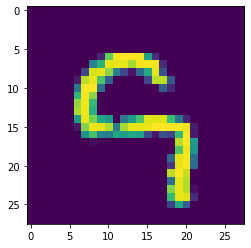

In [18]:
i=4
plt.imshow(advs_0[i].reshape((28, 28)))

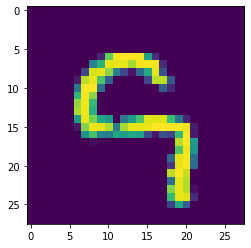

In [19]:
plt.imshow(advs_1[i].reshape((28, 28)))

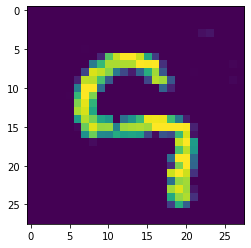

In [20]:
plt.imshow(advs_da[i].reshape((28, 28)))

In [25]:
advs_0_x = advs_0[4].flatten()
advs_1_x = advs_1[4].flatten()
advs_da_x = advs_da[4].flatten()

In [29]:
np.linalg.norm(advs_0_x - advs_1_x)

2.8115454e-07

In [31]:
np.linalg.norm(advs_da_x - advs_0_x)

0.503632

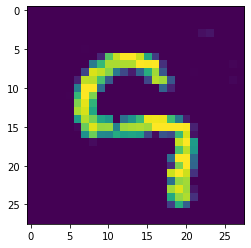

In [32]:
plt.imshow(advs_da_x.reshape((28, 28)))

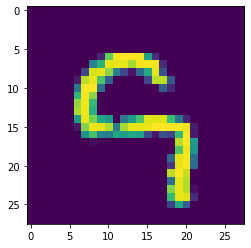

In [35]:
plt.imshow(advs_0_x.reshape((28, 28)))

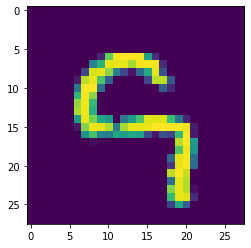

In [34]:
plt.imshow(advs_1_x.reshape((28, 28)))

# Generate adversarial examples

In [25]:
def generate_adv_example(model, X_test, y_test, X_train,
                         method = 'fgsm',
                         nb_adv = 1000):
    
    model_logits = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    ids = np.arange(nb_adv)
    np.random.shuffle(ids)
    X_to_adv = X_test[ids]
    y_adv = y_test[ids]
    print(X_to_adv.shape)
    
    if method == 'pfgsm':
        X_adv = projected_gradient_descent(model_logits, None, 0,
                                   X_to_adv,
                                   eps=2.,
                                   eps_iter=1.,
                                   nb_iter=10,
                                   norm=2,
                                   clip_min=X_train.min(),
                                   clip_max=X_train.max(),
                                   rand_init=None,
                                   rand_minmax=.3,
                                   targeted=False,
                                   sanity_checks=False
                                  ).numpy()
    elif method == 'fgsm':
        X_adv = fast_gradient_method(model_logits, 
                                     X_to_adv, 
                                     eps=3., 
                                     norm=2, 
                                     clip_min=X_train.min(), 
                                     clip_max=X_train.max(), 
                                     y=None,
                                     targeted=False, 
                                     sanity_checks=False).numpy()
    
    return X_to_adv, X_adv

def generate_adv_set(X_to_adv, X_adv):
    y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
    y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
    X_to_adv = X_to_adv[(y_pred != y_pred_adv)]
    X_adv = X_adv[(y_pred != y_pred_adv)]
    
    y_val = np.concatenate((np.zeros(len(X_to_adv)), np.ones(len(X_adv))))
    X_val = np.concatenate([X_to_adv, X_adv], axis=0)
    print(X_val.shape, y_val.shape)
    
    return X_val, y_val

In [26]:
X_to_adv, X_adv = generate_adv_example(model, X_test, y_test, X_train)

(1000, 28, 28, 1)


In [27]:
X_to_adv.shape

(1000, 28, 28, 1)

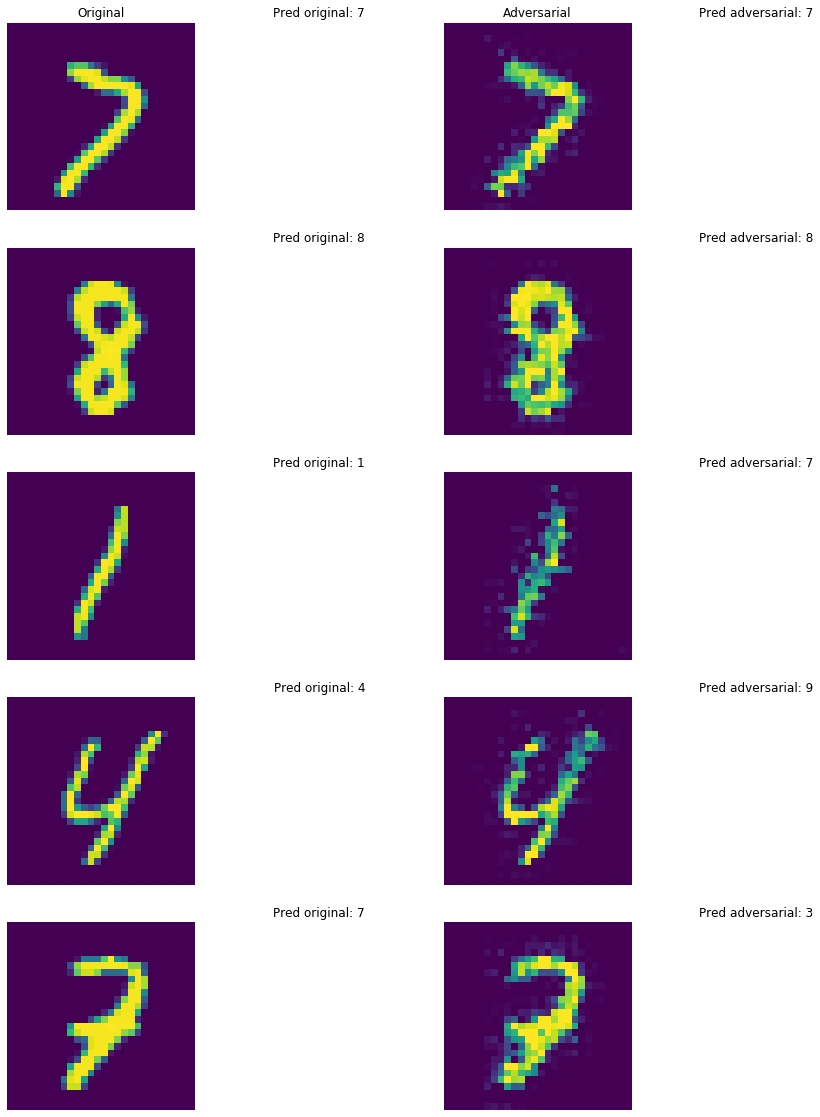

In [28]:
y_pred = np.argmax(model(X_to_adv).numpy(), axis=-1)
y_pred_adv = np.argmax(model(X_adv).numpy(), axis=-1)
meta_folder="../data/traffic/meta/"

n_rows = 5
n_cols = 4
figsize = (15, 20)
img_shape = (28, 28)

fig5 = plt.figure(constrained_layout=False, figsize=figsize)
widths = [5, 1, 5, 1]
heights = [5, 5, 5, 5, 5]
spec5 = fig5.add_gridspec(ncols=4, nrows=5, width_ratios=widths,
                          height_ratios=heights)

for row in range(n_rows):
    ax_0 = fig5.add_subplot(spec5[row, 0])    
    ax_0.imshow(X_to_adv[row].reshape(img_shape))
    if row == 0:
        ax_0.title.set_text('Original')
    ax_0.axis('off')
    
    ax_1 = fig5.add_subplot(spec5[row, 1])
    #class_image=cv2.imread(meta_folder+"{}.png".format(y_pred[row]))
    #image = Image.fromarray(class_image, 'RGB')
    #image = np.array(image)
    #ax_1.imshow(image)
    ax_1.title.set_text('Pred original: {}'.format(y_pred[row]))
    ax_1.axis('off')
    
    ax_2 = fig5.add_subplot(spec5[row, 2])
    ax_2.imshow(X_adv[row].reshape(img_shape))
    if row == 0:
        ax_2.title.set_text('Adversarial')
    ax_2.axis('off')
    
    ax_3 = fig5.add_subplot(spec5[row, 3])
    #class_image_adv=cv2.imread(meta_folder+"{}.png".format(y_pred_adv[row]))
    #image_adv = Image.fromarray(class_image_adv, 'RGB')
    #image_adv = np.array(image_adv)   
    #ax_3.imshow(image_adv)
    ax_3.title.set_text('Pred adversarial: {}'.format(y_pred_adv[row]))
    ax_3.axis('off')
        #label = 'Width: {}\nHeight: {}'.format(widths[col], heights[row])
        #ax.annotate(label, (0.1, 0.5), xycoords='axes fraction', va='center')